#### Load required libraries

In [1]:
import os
import numpy as np
from   scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

try:
    import pyviscous as vs 
except ImportError as e:
    import sys
    sys.path.append('../../')
    import pyviscous.pyviscous as vs

#### Load Rosenbrock function
In the two-dimensional form, the Rosenbrock function is defined as ([Rosenbrock, 1960](https://doi.org/10.1093/comjnl/3.3.175)):
$$ y = {100(x_2-x_1^2)^2 + (1-x_1)^2}, x_1, x_2 \in [-2,2] $$

In [2]:
def Rosenbrock_function(x):
    ''' Rosenbrock function
    -------
    x: input array, shape (nSample,2).
    y: output array, shape (nSample,1).'''
    
    y = 100*np.power(x[:,1]-np.power(x[:,0],2),2) + np.power(1-x[:,0],2)
    
    if len(np.shape(y)) == 1: # if shape(nSample,) -> (nSample,1)
        y = y.reshape(-1,1) 

    return y

#### Specify global input and output configurations

In [3]:
rootPath  = '.'  # root path where example data will be stored.
outputDir = os.path.join(rootPath,'outputs')
if not os.path.exists(outputDir):
    os.makedirs(outputDir)

nVar            = 2      # number of input x variables
paramLowerLimit = -2     # lower limit of x
paramUpperLimit = 2      # upper limit of x
nSample         = 10000  # number of input data samples

sampleFile      = os.path.join(outputDir,'samples_nVar%d.txt'%(nVar))
sampleCDFFile   = os.path.join(outputDir,'samplesCDF_nVar%d.txt'%(nVar))
sampleStdFile   = os.path.join(outputDir,'samplesStd_nVar%d.txt'%(nVar))

### Part 1. Generate & standradize data

#### Generate sample data

In [4]:
# Specify sample file.
if os.path.exists(sampleFile): # If exist, remove samples.
    os.remove(sampleFile)

# Generate input variable samples (x) 
x = np.zeros((nSample,nVar))
for iVar in range(nVar):
    prng = np.random.RandomState(iVar)
    x[:,iVar] = prng.uniform(low=paramLowerLimit, high=paramUpperLimit, size=nSample)               

# Generate the corresponding responses (y).
y = Rosenbrock_function(x)

# Save sample data.
samples    = np.concatenate((x,y), axis=1)    
header_str = ','.join(['X'+str(iVar+1) for iVar in range(nVar)])+',Y'
np.savetxt(sampleFile, samples, delimiter=',', header=header_str)
print('Samples data: %s'%(sampleFile))


Samples data: ./outputs/samples_nVar2.txt


#### Standardize sample data 

In [5]:
# Read sample data (x,y).
data = np.loadtxt(sampleFile, skiprows=0, delimiter=',')
x    = data[:,0:-1]
y    = data[:,-1].reshape(-1,1)    

# Standardize x.
[nSample, nVar] = np.shape(x)
cdfx = np.zeros_like(x)      # x CDF.
zx    = np.zeros_like(x)         # standardized data zx.  
for iVar in range(nVar):
    cdfx[:,iVar], zx[:,iVar] = vs.standardize_data(x[:,iVar])         

# Standardize y.
cdfy, zy = vs.standardize_data(y)

# Save CDF.
cdf_tmp    = np.concatenate((cdfx,cdfy), axis=1)    
header_str = ','.join(['X_CDF'+str(iVar+1) for iVar in range(nVar)])+',Y_CDF'
np.savetxt(sampleCDFFile,cdf_tmp,delimiter=',',header=header_str)
print('CDF data: %s'%(sampleFile))

# Save standardized data.
std_tmp    = np.concatenate((zx,zy), axis=1)    
header_str = ','.join(['X_STD'+str(iVar+1) for iVar in range(nVar)])+',Y_STD'
np.savetxt(sampleStdFile,std_tmp,delimiter=',',header=header_str)
print('Standardized data: %s'%(sampleFile))


CDF data: ./outputs/samples_nVar2.txt
Standardized data: ./outputs/samples_nVar2.txt


#### Plot sample data, CDF data, and standardized data
When we compute the first-order sensitivity index of $x_1$ for the Rosenbrock function, two variables $(x_1,y)$ need included in the VISCOUS framework. 
In this case, we get three sets of data: observation data $(x_1,y)$, CDF data $(u_{x_1},u_y)$, and standardized data $(z_{x_1},z_y)$.

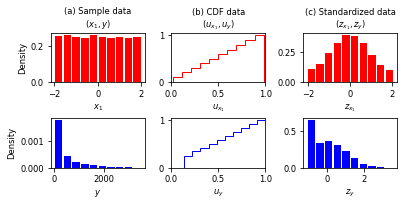

In [6]:
################## LOAD DATA #########################
# load raw data
data = np.loadtxt(sampleFile, skiprows=0, delimiter=',')
x    = data[:,0:-1]
y    = data[:,-1].reshape(-1,1)    

# load standardized data
data = np.loadtxt(sampleStdFile, skiprows=0, delimiter=',')
zx   = data[:,0:-1]
zy   = data[:,-1].reshape(-1,1)    

# load data cdf
data  = np.loadtxt(sampleCDFFile, skiprows=0, delimiter=',')
cdfx = data[:,0:-1]   
cdfy = data[:,-1].reshape(-1,1)    

# Plot (2,3) figures 
iVar   = 0          # evalaute x1 dimension
colors = ['r','b']  # for colors in different rows
titles = ["(a) Sample data\n$(x_1,y)$", "(b) CDF data\n$(u_{x_1},u_y)$", "(c) Standardized data\n$(z_{x_1},z_y)$"]  # for subtitles in different columns

#################### PLOT ###########################
# Plot observation data (𝑥1,𝑦) , CDF data (𝑢𝑥1,𝑢𝑦) , and standardized data (𝑧𝑥1,𝑧𝑦).
nrows = 2
ncols = 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols,constrained_layout=True, figsize=(5.5,2.7))

for icol in range(ncols):
    for irow in range(nrows):
        
        # identify data
        # (x1,y)
        if icol == 0 and irow == 0:
            data, xlabel = x[:,iVar], r"$x_1$"
        elif icol == 0 and irow == 1:
            data, xlabel = y, r"$y$"
        # (u1,uy)
        elif icol == 1 and irow == 0:
            data, xlabel = cdfx[:,iVar], r"$u_{x_1}$"
        elif icol == 1 and irow == 1:
            data, xlabel = cdfy, r"$u_y$"
        # (zx1,zy)
        elif icol == 2 and irow == 0:
            data, xlabel = zx[:,iVar], r"$z_{x_1}$"
        elif icol == 2 and irow == 1:
            data, xlabel = zy, r"$z_y$"
    
        # plot histogram
        if icol !=1:
            n, bins, patches = ax[irow,icol].hist(data, density=True, facecolor=colors[irow],rwidth=0.85)
        else:
            n, bins, patches = ax[irow,icol].hist(data, density=True, histtype='step',color=colors[irow],cumulative=True)
            ax[irow,icol].set_xlim(0,1) 
        
        # add title
        if irow == 0:
            ax[irow,icol].set_title(titles[icol],fontsize='small')#,weight='semibold')
        
        # add xlable and ylabel
        ax[irow,icol].set_xlabel(xlabel,fontsize='small') 
        if icol == 0:
            ax[irow,icol].set_ylabel('Density',fontsize='small')
        ax[irow,icol].tick_params(axis='x', labelsize='small')
        ax[irow,icol].tick_params(axis='y', labelsize='small')       

plt.savefig(os.path.join(outputDir,'sample_transform.png'),dpi=150)
plt.show() 


### Part 2. Calculate first-order sensitivity indices (Two components)

In [7]:
# Load sample data
data = np.loadtxt(sampleFile, skiprows=0, delimiter=',')
x    = data[:,0:-1]
y    = data[:,-1].reshape(-1,1)    

# Load standardized data
data = np.loadtxt(sampleStdFile, skiprows=0, delimiter=',')
zx   = data[:,0:-1]
zy   = data[:,-1].reshape(-1,1)    

# Specify VISCOUS configurations
sensType     = 'first'    # two options for sensitivity index calculation: 'first' or 'total' 

GSAIndex     = [[0]]       # Index 0 refers to the 1st input variable x1, meaning we aim to calculate the sensitivity index of x1.                     
                           # use vs.define_GSA_variable_index(nVar) if you want to compute each x variable' sensitivity indcies.
                           # use [[0],[1]] if you want to compute the sensitivity indices of x1 and x2.

N1, N2       = 10000, 10000   # Monte Carlo sample size. N1 is for outer loop, N2 is for inner loop.

n_components = 2          # The number of components used in GMM inference. An integer or string "optimal". 
                          # If n_components is an integer, it will be used as the fixed user-provided number of components.
                          # If n_components is "optimal", it will look for an optimal number of components in the range of [1, n_xvariables+20].

# Calculate sensitivity indices using VISCOUS
sensIndex_2Cpnt, fitted_gmm_ls_2Cpnt = vs.VISCOUS(x, y, zx, zy, sensType, GSAIndex, N1, N2, n_components)  


Calculating first-order sensitivity indices...
--- variable group [0] --- 
--- fitting GMM...
--- calculating sensitivity index...
--- Sensitivity index = 0.296010



#### Look at sensitivity indices and Gaussian mixture model (GMM) results (Two components)

In [8]:
# Look at sensitivity indices 
for iGSA in range(len(GSAIndex)):
    if len(GSAIndex[iGSA])==1:
        print('S%d = %.4f'%(GSAIndex[iGSA][0]+1, sensIndex_2Cpnt[iGSA]))
    else:
        var_label = ''
        for ind in GSAIndex[iGSA]:
            var_label = var_label+'%d,'%(ind+1)
        var_label = var_label.rstrip(',')
        print('S%s = %.4f'%(var_label, sensIndex_2Cpnt[iGSA]))

S1 = 0.2960


In [9]:
# Check details of the best fitted GMM
gmm = fitted_gmm_ls_2Cpnt[0]
gmmWeights     = gmm.weights_      # shape (n_components,)
gmmMeans       = gmm.means_        # shape (n_components, n_variables). n_variables = n_feature in sklearn.mixture.GaussianMixture reference.
gmmCovariances = gmm.covariances_  # (n_components, n_variables, n_variables) if covariance_type = ‘full’ (by default).    
gmmNComponents = gmm.n_components  # number of components
print('gmmNComponents=%d'%gmmNComponents)


gmmNComponents=2


#### Plot GMM cluster and PDF (Two components)

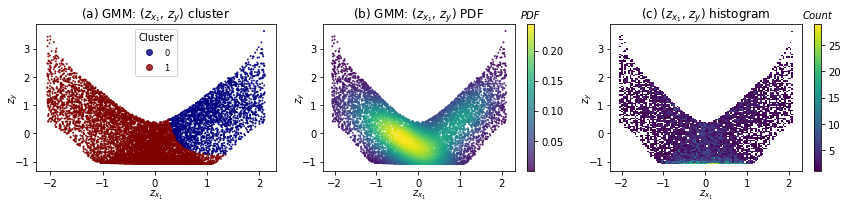

In [10]:
# Plot the 1st variable group x1's GMM, so index is 0.
gmm     = fitted_gmm_ls_2Cpnt[0]
GSA_idx = GSAIndex[0]
ofile   = os.path.join(outputDir,'gmm_cluster_pdf_2Cpnt.png')

vs.plot_gmm_cluster_pdf(gmm,zx,zy,GSA_idx,ofile)

#### Plot contours of each component and GMM (Two components)

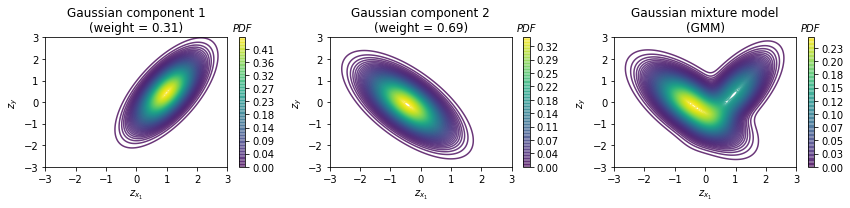

In [11]:
###############################################################################
#  Compute GMM PDF and invidivual componnet PDF at mesh grid points

# (1) Create mesh grid on (zx1,zy) dimensions for contour plot
gmm                = fitted_gmm_ls_2Cpnt[0]
gmmWeights         = gmm.weights_          # shape (n_components,)
gmmMeans           = gmm.means_            # shape (n_components, n_variables). n_variables = n_feature in sklearn.mixture.GaussianMixture reference.
gmmCovariances     = gmm.covariances_      # (n_components, n_variables, n_variables) if covariance_type = ‘full’ (by default).    
gmmNComponents     = gmm.n_components      # number of components

N                  = 1000                   # number of samples used in uniform sampling to create mesh grid
zx_uniform_samples = np.linspace(-3, 3, N)  # uniform samples in zx space [-3, 3] given the range of the standard normal distribution.
zy_uniform_samples = np.linspace(-3, 3, N)  # uniform samples in zy space [-3, 3]. 

zx_uniform_samples = zx_uniform_samples.reshape(-1,1) # reshape into (N,1)
zy_uniform_samples = zy_uniform_samples.reshape(-1,1) # reshape into (N,1)

X, Y = np.meshgrid(zx_uniform_samples, zy_uniform_samples)  # create mesh over N-N grids

# (2) Loop to calculate GMM PDF and invidivual component PDF per mesh grid point
jointPDF = np.zeros((N,N))                    # GMM PDF, dimension is (x,y).
jointPDFCpnt = np.zeros((N,N,gmmNComponents)) # Individual component PDF, dimension is (x,y,component).

# Loop zx 
for i in range(N):  
    xx, yy = zx_uniform_samples[i],zy_uniform_samples
    
    # Given xx, handle N zy samples using vector operations   
    # Calculate GMM PDF.
    multivariateData = np.concatenate((np.ones((N,1))*xx,yy), axis=1)  # combine x and y into a multi-variate data array. Shape (N, nVar+1).
    logProb          = gmm.score_samples(multivariateData)             # compute the log probability of multivariateData under the model.
    jointPDF[:,i]    = np.exp(logProb)                                 # get the joint probability of multivariateData of GMM.
    
    # Calculate individual component PDF.
    for iComponent in range(gmmNComponents):
        jointPDFCpnt[:,i,iComponent] = multivariate_normal.pdf(multivariateData, mean=gmmMeans[iComponent,:], 
                                                cov=gmmCovariances[iComponent,:,:]) 

###############################################################################
# Plot GMM PDF and invidivual componnet PDF in contours
fs        = 'medium'  # plot font size
ncols     = 3         # three subplots per row
nrows     = int(np.ceil((gmmNComponents+1)/ncols)) # number of rows given ncols and gmmNComponents
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(4*ncols,3*nrows))

# If the plot has only one row.
if nrows==1: 
    for icol in range(ncols):
        count = icol

        if count <= (gmmNComponents):
            if count == gmmNComponents:
                im = axes[icol].contour(X, Y, jointPDF, alpha=0.8,levels=100,cmap='viridis')
                axes[icol].set_title('Gaussian mixture model\n(GMM)')
            else:
                iComponent = count
                im = axes[icol].contour(X, Y, jointPDFCpnt[:,:,iComponent], alpha=0.8,levels=100,cmap='viridis')                
                axes[icol].set_title('Gaussian component %d\n(weight = %.2f)'%(iComponent+1, gmmWeights[iComponent]))

            # Set colorbar and tick label
            kwargs = {'format': '%.2f'}
            cbar = plt.colorbar(im, ax=axes[icol], **kwargs)
            cbar.ax.set_title('PDF',fontsize=fs, style='italic')    
            
            axes[icol].set_xlabel(r"$z_{x_1}$")
            axes[icol].set_ylabel(r"$z_y$")
        else:
            axes[icol].axis('off')

# If the plot has more than one rows.
elif nrows>1: 
    for irow in range(nrows):
        for icol in range(ncols):
            count = irow*ncols + icol 

            if count <= (gmmNComponents):
                if count == gmmNComponents:
                    im = axes[irow,icol].contour(X, Y, jointPDF, alpha=0.8,levels=100,cmap='viridis')
                    axes[irow,icol].set_title('Gaussian mixture model\n(GMM)')
                else:
                    iComponent = count
                    im = axes[irow,icol].contour(X, Y, jointPDFCpnt[:,:,iComponent], alpha=0.8,levels=100,cmap='viridis')                
                    axes[irow,icol].set_title('Gaussian component %d\n(weight = %.2f)'%(iComponent+1, gmmWeights[iComponent]))

                # Set colorbar and tick label
                kwargs = {'format': '%.2f'}
                cbar = plt.colorbar(im, ax=axes[irow,icol], **kwargs)
                cbar.ax.set_title('PDF',fontsize=fs, style='italic')
                
                axes[irow,icol].set_xlabel(r"$z_{x_1}$",fontsize=fs)
                axes[irow,icol].set_ylabel(r"$z_y$",fontsize=fs)
            else:
                axes[irow,icol].axis('off')


plt.tight_layout()
plt.savefig(os.path.join(outputDir,'gmm_contour.png'), dpi=150)
plt.show() 


### Part 3. Calculate first-order sensitivity indices (Optimal components)

In [12]:
# Load raw data
data = np.loadtxt(sampleFile, skiprows=0, delimiter=',')
x    = data[:,0:-1]
y    = data[:,-1].reshape(-1,1)    

# Load standardized data
data = np.loadtxt(sampleStdFile, skiprows=0, delimiter=',')
zx   = data[:,0:-1]
zy   = data[:,-1].reshape(-1,1)    

# Specify VISCOUS configurations
sensType     = 'first'    # two options for sensitivity index calculation: 'first' or 'total' 

GSAIndex     = [[0]]       # Index 0 refers to the 1st input variable x1, meaning we aim to calculate the sensitivity index of x1.                     
                           # use vs.define_GSA_variable_index(nVar) if you want to compute each x variable' sensitivity indcies.
                           # use [[0],[1]] if you want to compute the sensitivity indices of x1 and x2.

N1, N2       = 10000, 10000   # Monte Carlo sample size. N1 is for outer loop, N2 is for inner loop.

n_components = 'optimal'  # The number of components used in GMM inference. An integer or string "optimal". 
                          # If n_components is an integer, it will be used as the fixed user-provided number of components.
                          # If n_components is "optimal", it will look for an optimal number of components in the range of [1, n_xvariables+20].

sensIndex_optimalCpnt, fitted_gmm_ls_optimalCpnt = vs.VISCOUS(x, y, zx, zy, sensType, GSAIndex, N1, N2, n_components)  


Calculating first-order sensitivity indices...
--- variable group [0] --- 
--- fitting GMM...
--- calculating sensitivity index...
--- Sensitivity index = 0.480156



#### Look at sensitivity indices and Gaussian mixture model (GMM) results (Optimal components)

In [13]:
# Look at sensitivity indices 
for iGSA in range(len(GSAIndex)):
    if len(GSAIndex[iGSA])==1:
        print('ST%d = %.4f'%(GSAIndex[iGSA][0]+1, sensIndex_optimalCpnt[iGSA]))
    else:
        var_label = ''
        for ind in GSAIndex[iGSA]:
            var_label = var_label+'%d,'%(ind+1)
        var_label = var_label.rstrip(',')
        print('ST%s = %.4f'%(var_label, sensIndex_optimalCpnt[iGSA]))

ST1 = 0.4802


In [14]:
# check GMM result details
gmm            = fitted_gmm_ls_optimalCpnt[0]
gmmWeights     = gmm.weights_      # shape (n_components,)
gmmMeans       = gmm.means_        # shape (n_components, n_variables). n_variables = n_feature in sklearn.mixture.GaussianMixture reference.
gmmCovariances = gmm.covariances_  # (n_components, n_variables, n_variables) if covariance_type = ‘full’ (by default).    
gmmNComponents = gmm.n_components  # number of components
print('gmmNComponents=%d'%gmmNComponents)


gmmNComponents=18


#### Plot GMM cluster and PDF (Optimal components)

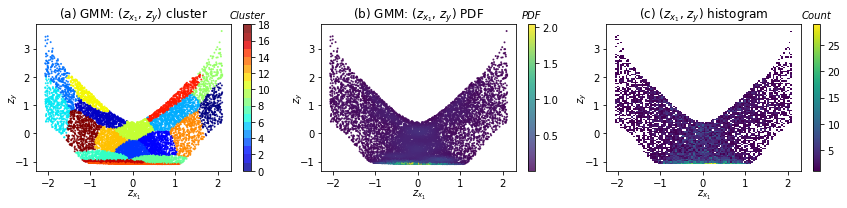

In [15]:
# Plot the 1st variable group x1's GMM, so index is 0.
gmm     = fitted_gmm_ls_optimalCpnt[0]
GSA_idx = GSAIndex[0]
ofile   = os.path.join(outputDir,'gmm_cluster_pdf_optimalCpnt.png')

vs.plot_gmm_cluster_pdf(gmm,zx,zy,GSA_idx,ofile)